In [2]:
using Plots
using Statistics
using LinearAlgebra
using JSON

include("readclassjson.jl");

In [4]:
# ; wget http://ee263.stanford.edu/hw/gauss_fit_data.json -P data

## 7.1040 Gauss Newton Method
Get the data $t, y($ and $N)$ from the file gauss_fit_data. $\mathrm{m},$ available on the class website. Implement the Gauss-Newton (as outlined in part
(a) above). You'll need an initial guess for the parameters. You can visually estimate them (giving a short justification), or estimate them by any other method (but you must explain your method). Plot the RMS error $E$ as a function of the iteration number. (You should plot enough iterations to convince yourself that the algorithm has nearly converged.) Plot the final Gaussian function obtained along with the data on the same plot. Repeat for another reasonable, but different initial guess for the parameters. Repeat for another set of parameters that is not reasonable, i.e., not a good guess for the parameters. (It's possible, of course, that the Gauss-Newton algorithm doesn't converge, or fails at some step; if this occurs, say
so.) Briefly comment on the results you obtain in the three cases.

In [97]:
gaussian = readclassjson("data/gauss_fit_data.json")

Dict{Any,Any} with 3 entries:
  "N" => 200
  "t" => [0.0, 0.502513, 1.00503, 1.50754, 2.01005, 2.51256, 3.01508, 3.51759, …
  "y" => [3.5784, 0.7447, 3.557, 0.1211, 4.1369, -1.8362, 3.0537, 1.0934, 1.090…

In [98]:
t = gaussian["t"]
y = gaussian["y"];

Define initial parameters: initial guesses for $mu$ and $\sigma$ use the rough empirical mean and standard deviation for t since this aligns with the definition of a Gaussian distribution. The normalizing constant was initialized by plugging those parameters into $f(t)$ with $a_0 = 1$ and taking $y / f(t)$ to see how different the scales were. This turned out to be roughly 20.

In [149]:
mu0 = 50
sigma0 = std(t)
a0 = 20

p0 = [a0 ; mu0; sigma0]

3-element Array{Float64,1}:
 20.0
 50.0
 29.085017343694034

In [178]:
function normal(t, p)
    p[1] .* exp.(-(t .- p[2]).^2 ./ (p[3]^2))
end

function rmse(p)
    sqrt(1/gaussian["N"]) * norm(normal(t, p) .- y)
end

function jacobian(p)
    f = normal(t, p)
    dr = 2 * (f .- y)
    exponent = exp.(-(t .- p[2]).^2 ./ (p[3]^2))
    da =  dr .* exponent
    dm =  dr .* ((2*p[1] .*(t .- p[2]))./ (p[3]^2)).* exponent
    ds =  dr .* ((2*p[1] .*((t .- p[2]).^2))./ (p[3]^3)).* exponent
    
    j = [da dm ds]
end

jacobian (generic function with 1 method)

In [218]:
function fitter(p0, iters=100)
    p = p0
    rmse_vec = zeros(iters)
    for i = 1:iters
        Jk = jacobian(p)
        Ak = Jk
        bk = Jk * p .- rmse(p)

        F = qr(Ak)
        p_k1 = inv(F.R) * transpose(F.Q[:,1:3]) * bk

        rmse_vec[i] = rmse(p)

        p = p_k1
        
    end
    return(p, rmse_vec)
end

fitter (generic function with 2 methods)

In [196]:
p1, rmse_vec1 = fitter(p0);

Output parameter values for converged solution

In [233]:
p1

3-element Array{Float64,1}:
 12.098632354668037
 54.80866643570745
 42.021670289800674

The G-N method converges within 25 iterations when we use the reasonable initialized parameters

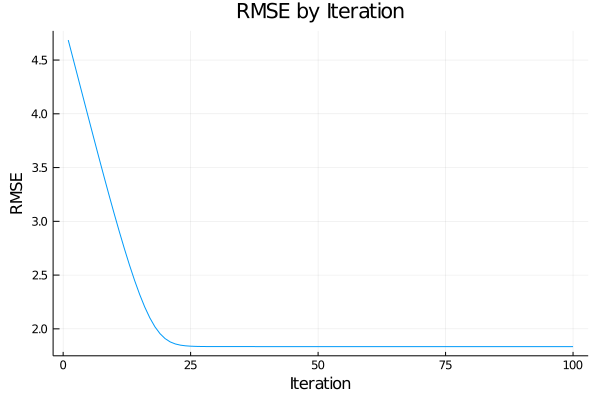

In [205]:
plot(rmse_vec1, label=false)
title!("RMSE by Iteration")
xlabel!("Iteration")
ylabel!("RMSE")

The estimated parameters fit the data very well.

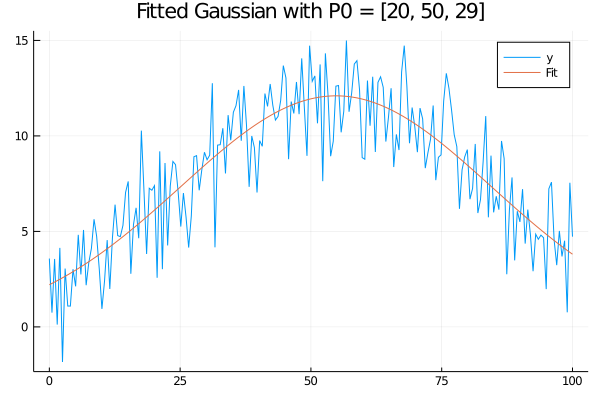

In [210]:
plot(t, y, label = "y")
plot!(t, normal(t, p1), label="Fit")
title!("Fitted Gaussian with P0 = [20, 50, 29]")

With a new guess within a reasonable range, we still get convergence and a good fit. Note from the RMSE plot that convergence takes somewhat longer.

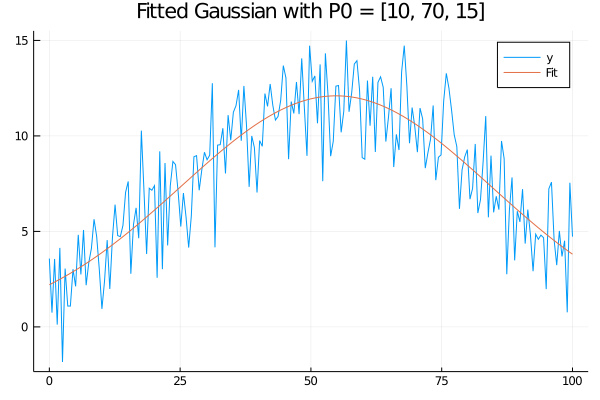

In [214]:
p02 = [10, 70, 15]
p2, rmse_vec2 = fitter(p02);
plot(t, y, label = "y")
plot!(t, normal(t, p2), label="Fit")
title!("Fitted Gaussian with P0 = [10, 70, 15]")

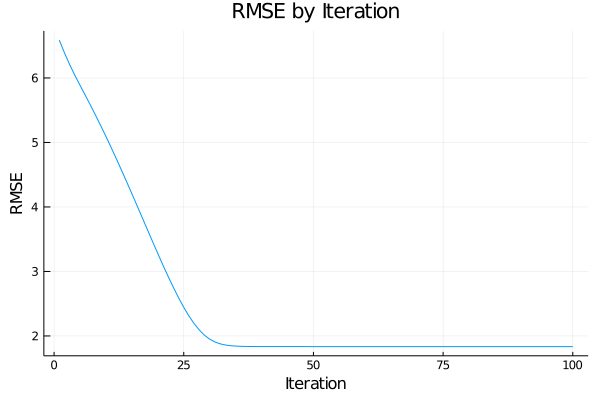

In [235]:
plot(rmse_vec2, label=false)
title!("RMSE by Iteration")
xlabel!("Iteration")
ylabel!("RMSE")

With a very unreasonable guess, the algorithm did not converge and we are not left with a solution

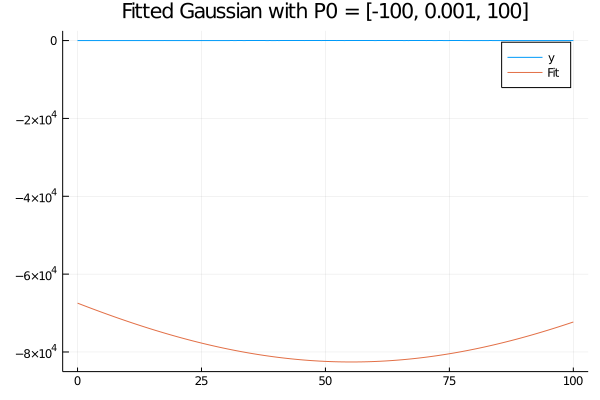

In [231]:
p03 = [-100, 0.001, 100]
p3, rmse_vec3 = fitter(p03, 500);
plot(t, y, label = "y")
plot!(t, normal(t, p3), label="Fit")
title!("Fitted Gaussian with P0 = [-100, 0.001, 100]")

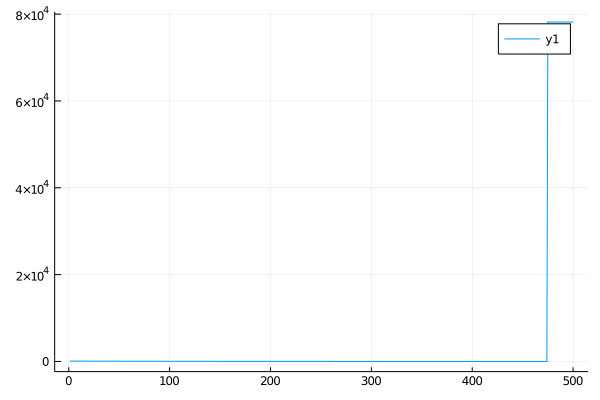

In [232]:
plot(rmse_vec3)

Therefore we see that Gauss-Newton works quite well with good initialization. Even with guesses that are off from the truth, it still converges in reasonable time. However some domain knowledge is warranted to avoid divergence